In [0]:
#!mkdir Signature
#!cd Signature

In [0]:
!wget http://www.iapr-tc11.org/dataset/ICDAR_SignatureVerification/SigComp2011/sigComp2011-trainingSet.zip

In [0]:
!unzip -P "I hereby accept the SigComp 2011 disclaimer." sigComp2011-trainingSet.zip

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

In [0]:
!pip3 install torchvision

In [0]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
import random

%matplotlib inline

In [0]:
#imports

from __future__ import print_function, division
import torch
import torch.nn as nn
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn.functional as F

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [0]:
#PATHS

current_dir = os.path.dirname('./')

genuine_folder = os.path.join(current_dir, 'trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Genuine')
forgeries_folder = os.path.join(current_dir, 'trainingSet/OfflineSignatures/Chinese/TrainingSet/Offline Forgeries')   

In [0]:
'''
CROPPING & RESIZING TRAINING DATA
'''

# Image trimming function
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

#Genuine Data

genuine_data = []
genuine_label = []
for filename in os.listdir(genuine_folder):
    im = Image.open(os.path.join(genuine_folder, filename), 'r')       
    im = trim(im)                                                     #trimming images roughly till the borders
    
    imgnd = np.array(im)
    
    img = cv2.cvtColor(imgnd, cv2.COLOR_RGB2BGR)                      #converting PIL image to CV2 image
    h, w, d = img.shape                                               #getting dimesnions of image
    
    crop_img = img[30:h-30, 30:w-30]                                  #cropping 30+30 pixels extra to remove slant borders
    height, width, depth = crop_img.shape                             # getting gimesnions of cropped image
    
    img_padded = cv2.copyMakeBorder(crop_img,
                                    (350-(height-int(height/2))), (350-int(height/2)), (550-int(width/2)), (550-(width-int(width/2))),
                                    cv2.BORDER_CONSTANT, value = [255,255,255])
    crop_img_final = img_padded[200:600, 100:900]
    
    genuine_data.append(crop_img_final)
    genuine_label.append(filename)
    
#Forgeries Data

forgeries_data = []
forged_label = []
for filename in os.listdir(forgeries_folder):
    im = Image.open(os.path.join(forgeries_folder, filename), 'r')
    im = trim(im)                                                     #trimming images roughly till the borders
    
    imgnd = np.array(im)
    
    img = cv2.cvtColor(imgnd, cv2.COLOR_RGB2BGR)                      #converting PIL image to CV2 image
    h, w, d = img.shape                                               #getting dimesnions of image
    
    crop_img = img[30:h-30, 30:w-30]                                  #cropping 30+30 pixels extra to remove slant borders
    height, width, depth = crop_img.shape                             # getting gimesnions of cropped image
    
    img_padded = cv2.copyMakeBorder(crop_img,
                                    (350-(height-int(height/2))), (350-int(height/2)), (550-int(width/2)), (550-(width-int(width/2))),
                                    cv2.BORDER_CONSTANT, value = [255,255,255])
    crop_img_final = img_padded[200:600, 100:900]
    
    forgeries_data.append(crop_img_final)
    forged_label.append(filename)
    

In [0]:
#Resized images 800 x 1600 numpy arrays

genuine_signs = np.array(genuine_data)
forged_signs = np.array(forgeries_data)

In [0]:
#names of images

genuine_labels = np.array(genuine_label)
forged_labels = np.array(forged_label)

In [12]:
print(genuine_signs.shape)
print(forged_signs.shape)

(235, 400, 800, 3)
(340, 400, 800, 3)


In [13]:
print(genuine_labels.shape)
print(forged_labels.shape)

(235,)
(340,)


In [0]:
#Getting author labels

glabels = np.zeros((genuine_labels.shape[0]))
for i in range (genuine_labels.shape[0]):
    for j in range (10):
        if int(genuine_labels[i][1:3]) == (j+1):
            glabels[i] = int(genuine_labels[i][1:3])  #author 1 to 10 are genuine
            
flabels = np.zeros((forged_labels.shape[0]))
for i in range (forged_labels.shape[0]):
    for j in range (16):
        if int(forged_labels[i][2:4]) == (j+1):
            flabels[i] = int(forged_labels[i][2:4])  
            
flabels = flabels + 10  #author 11 to 26 are forged....with forged author index = flabel - 10 

7.0


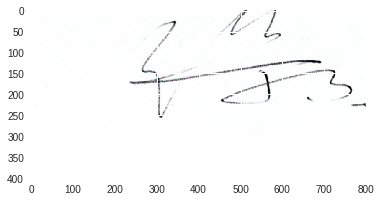

In [15]:
#Testing resized genuine image
print(glabels[200])
imgplot = plt.imshow(genuine_signs[200])  

19.0


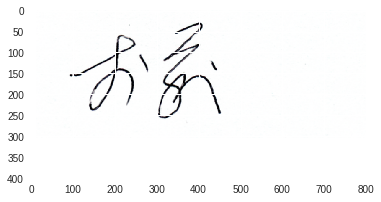

In [16]:
#Testing resized forged image
print(flabels[5])
imgplot = plt.imshow(forged_signs[5])  

In [0]:
x_train = np.concatenate((genuine_signs, forged_signs))
y_train = np.concatenate((glabels, flabels))

In [0]:
x_train = x_train.transpose((0, 3, 1, 2))

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,x_train, y_train):
        self.x_train = x_train   
        self.y_train = y_train
        
    def __getitem__(self,index):
        
        index1 = random.randrange(len(self.x_train))
        
        img1 = x_train[index1]
        label1 = y_train[index1]
        
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                index2 = random.randrange(len(x_train))
                label2 = y_train[index2]
                if label1 == label2:
                    img2 = x_train[index2]
                    break
        else:
            index2 = random.randrange(len(x_train))
            img2 = x_train[index2]
            label2 = y_train[index2]
            
        img1 = torch.from_numpy(img1)
        img2 = torch.from_numpy(img2)
        
        img1 = img1.long()
        img2 = img2.long()
        
        label = torch.from_numpy(np.array(int((label1 != label2))))
        #label = label.long()
        
        return img1, img2 , label 
    
    def __len__(self):
        return len(x_train)

In [0]:
siamese_dataset = SiameseNetworkDataset(x_train = x_train,
                                       y_train = y_train)

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=100)


In [0]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        label = label.type(torch.cuda.FloatTensor)
        #print(label)
        #label
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
class RajSiameseNetwork(nn.Module):
        def __init__(self):
          super(RajSiameseNetwork, self).__init__()

          #Convolution 1
          self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 1, padding = 2)
          self.relu1 = nn.ReLU()
          self.norm1 = nn.BatchNorm2d(16)

          #maxpool1
          self.maxpool1 = nn.MaxPool2d(kernel_size = 2)


          #convolution2
          self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
          self.relu2 = nn.ReLU()
          self.norm2 = nn.BatchNorm2d(32)

          #maxpool2
          self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
          
          
          #convolution3
          self.cnn3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
          self.relu3 = nn.ReLU()
          self.norm3 = nn.BatchNorm2d(32)

          #maxpool3
          self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
          
          
          #convolution4
          self.cnn4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
          self.relu4 = nn.ReLU()
          self.norm4 = nn.BatchNorm2d(32)

          #maxpool4
          self.maxpool4 = nn.MaxPool2d(kernel_size = 2)
          
          #convolution5
          self.cnn5 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
          self.relu5 = nn.ReLU()
          self.norm5 = nn.BatchNorm2d(32)

          #maxpool5
          self.maxpool5 = nn.MaxPool2d(kernel_size = 2)



          #FC layer
          self.fc1 = nn.Linear(32*6*10, 32*6*10)

          #relu3
          self.relu3 = nn.ReLU()
          self.fc2 = nn.Linear(32*6*10, 32*6*10)

        def forward_once(self, x):
          #cnn1
          out = self.cnn1(x)
          out = self.relu1(out)
          out = self.norm1(out)

          #maxpool1
          out = self.maxpool1(out)
          m = nn.Dropout2d(p=0.2)
          out = m(out)

          #cnn2
          out = self.cnn2(out)    
          out = self.relu2(out)
          out = self.norm2(out)

          #maxpool2
          out = self.maxpool2(out)
          m = nn.Dropout2d(p=0.2)
          out = m(out)
          
          #cnn3
          out = self.cnn3(out)    
          out = self.relu3(out)
          out = self.norm3(out)

          #maxpool3
          out = self.maxpool3(out)
          m = nn.Dropout2d(p=0.2)
          out = m(out)
          
          #cnn4
          out = self.cnn4(out)    
          out = self.relu4(out)
          out = self.norm4(out)

          #maxpool4
          out = self.maxpool4(out)
          m = nn.Dropout2d(p=0.2)
          out = m(out)
          
          #cnn5
          out = self.cnn5(out)    
          out = self.relu5(out)
          out = self.norm5(out)

          #maxpool5
          out = self.maxpool5(out)
          m = nn.Dropout2d(p=0.2)
          out = m(out)
          
          #cnn6
          out = self.cnn5(out)    
          out = self.relu5(out)
          out = self.norm5(out)

          #maxpool5
          out = self.maxpool5(out)
          m = nn.Dropout2d(p=0.2)
          out = m(out)
          
          #resize 
          out = out.view(out.size(0), -1)
          out = 10000 * out

          #linear function (readout)
          #out = self.fc1(out)

          #out = self.relu3(out)
          #out = self.fc2(out)

        def forward(self, input1, input2):
          output1 = self.forward_once(input1)
          output2 = self.forward_once(input2)
          return output1, output2

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout2d(p=0.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout2d(p=0.2),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout2d(p=0.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size = 5, stride = 1, padding = 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout2d(p=0.2),


        )
      

        self.fc1 = nn.Sequential(
            nn.Linear(10608, 500),           #should be 10000 x 500
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        output = output
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [36]:
for epoch in range(0,100):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, label = data
        img0 = img0.float()
        img1 = img1.float()
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        #print(img0)
        #print(img1)
        output1,output2 = net(img0,img1)
        #print(output1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())


Epoch number 0
 Current loss 1.4290812015533447

Epoch number 1
 Current loss 1.0630866289138794

Epoch number 2
 Current loss 1.0330480337142944

Epoch number 3
 Current loss 1.0146353244781494

Epoch number 4
 Current loss 0.8903472423553467

Epoch number 5
 Current loss 0.834700882434845

Epoch number 6
 Current loss 0.7481083273887634

Epoch number 7
 Current loss 0.7760414481163025

Epoch number 8
 Current loss 0.8179765343666077

Epoch number 9
 Current loss 0.6447890996932983

Epoch number 10
 Current loss 0.625473141670227

Epoch number 11
 Current loss 0.5905139446258545

Epoch number 12
 Current loss 0.49135062098503113

Epoch number 13
 Current loss 0.5751019716262817

Epoch number 14
 Current loss 0.6089391708374023

Epoch number 15
 Current loss 0.4926358163356781

Epoch number 16
 Current loss 0.5086678862571716

Epoch number 17
 Current loss 0.44655656814575195

Epoch number 18
 Current loss 0.39821529388427734

Epoch number 19
 Current loss 0.46961352229118347

Epoch nu

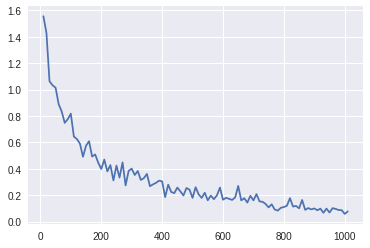

In [37]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

show_plot(counter,loss_history)

In [0]:
torch.save(net, 'net.pt')

In [0]:
net = torch.load('net.pt')